The example in this notebook is taken from this [book](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

tf.random.set_seed(42)
np.random.seed(42)

In [0]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 2 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 3 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.5 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [0]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:, :n_steps], series[7000:, -1]

In [4]:
# shape = (num_examples, num_time_steps, feature_space_dim)
X_train.shape 

(7000, 50, 1)

In [5]:
y_train.shape

(7000, 1)

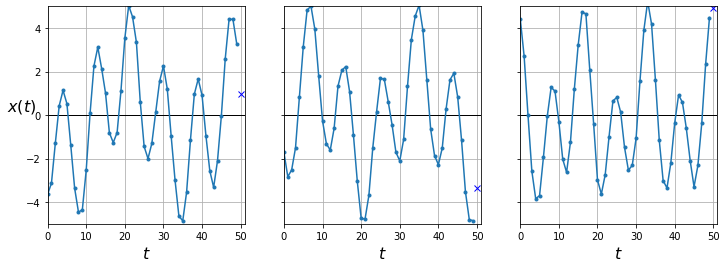

In [48]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -5, 5])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### Baseline naive prediction for comparison

In [49]:
y_pred = X_valid[:, -1]
np.mean(tf.keras.losses.mean_squared_error(y_valid, y_pred))

1.8750325

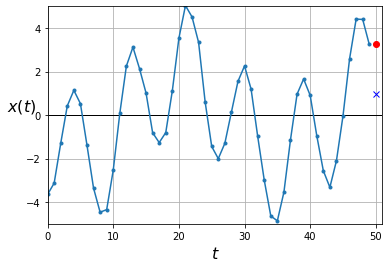

In [50]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Dense network

In [13]:
tf.random.set_seed(42)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[50, 1]))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

loss = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.SGD()

model.compile(loss=loss, optimizer=opt)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.8432 - val_loss: 0.3045
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.2393 - val_loss: 0.2071
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1892 - val_loss: 0.1702
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1661 - val_loss: 0.1668
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1506 - val_loss: 0.1737
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1425 - val_loss: 0.1422
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1356 - val_loss: 0.1518
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1300 - val_loss: 0.1433
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1267 - val_loss: 0.1350
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1255 - val_loss: 0.1222

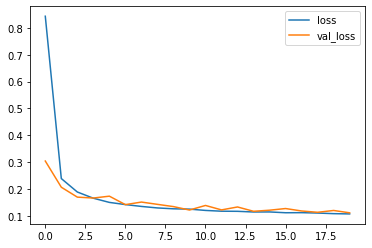

In [14]:
pd.DataFrame(history.history).plot()

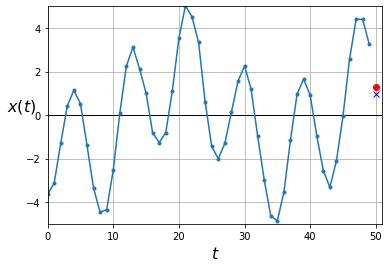

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a simple RNN

In [16]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]))
model.add(tf.keras.layers.Dense(1))

optimizer = tf.keras.optimizers.SGD()
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 10ms/step - loss: 0.3471 - val_loss: 0.1683
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1544 - val_loss: 0.1393
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1375 - val_loss: 0.1328
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1275 - val_loss: 0.1204
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1207 - val_loss: 0.1150
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1149 - val_loss: 0.1164
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1086 - val_loss: 0.1036
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1026 - val_loss: 0.0971
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0983 - val_loss: 0.0919
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0935 - val_loss: 0.089

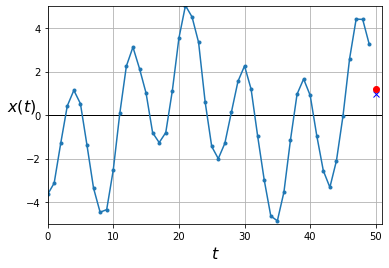

In [17]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

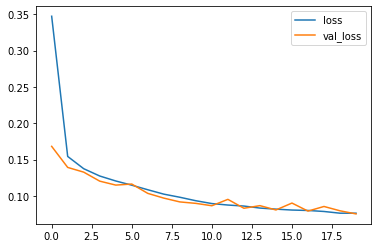

In [18]:
pd.DataFrame(history.history).plot()

### Deep RNN

In [20]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]))
model.add(tf.keras.layers.SimpleRNN(32))
model.add(tf.keras.layers.Dense(1))

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 19ms/step - loss: 0.4660 - val_loss: 0.1473
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.1247 - val_loss: 0.1028
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0941 - val_loss: 0.0851
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0838 - val_loss: 0.0788
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0764 - val_loss: 0.0769
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0728 - val_loss: 0.0727
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0703 - val_loss: 0.0711
Epoch 8/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0708 - val_loss: 0.0690
Epoch 9/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0672 - val_loss: 0.0729
Epoch 10/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0650 - val_lo

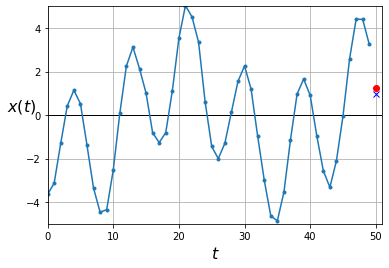

In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

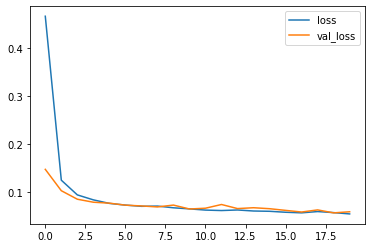

In [22]:
pd.DataFrame(history.history).plot()

### Forecasting several steps

In [0]:
np.random.seed(43)

#Create a single sequence to see how the previous model does
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [24]:
Y_pred.shape

(1, 10, 1)

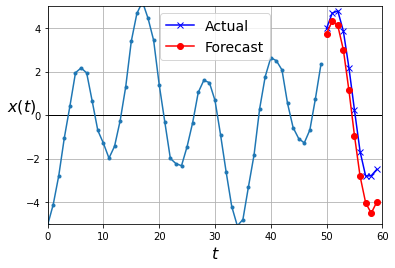

In [25]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Forecast")
    plt.axis([0, n_steps + ahead, -5, 5])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:, :n_steps], series[7000:, -10:, 0]

In [0]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [28]:
Y_pred.shape

(3000, 10)

In [29]:
np.mean(tf.keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.62709093

In [33]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]))
model.add(tf.keras.layers.SimpleRNN(32))
model.add(tf.keras.layers.Dense(10))

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.MeanSquaredError()
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 19ms/step - loss: 3.3468 - val_loss: 1.9417
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 1.1902 - val_loss: 0.6594
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.5504 - val_loss: 0.4672
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.3986 - val_loss: 0.4111
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.3200 - val_loss: 0.2699
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.2738 - val_loss: 0.2423
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.2406 - val_loss: 0.2184
Epoch 8/20
219/219 [==============================] - 4s 18ms/step - loss: 0.2195 - val_loss: 0.3343
Epoch 9/20
219/219 [==============================] - 4s 18ms/step - loss: 0.2073 - val_loss: 0.2414
Epoch 10/20
219/219 [==============================] - 4s 18ms/step - loss: 0.1879 - val_lo

In [0]:
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

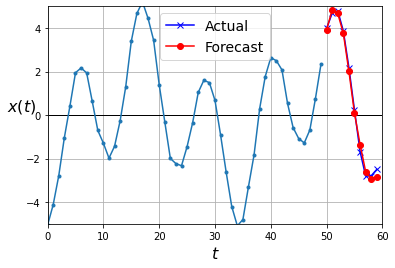

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()